In [3]:
import sys
sys.path.insert(0,'/Users/tiagorodrigues/Documents/GitHub/NeuroKit')

import os
import wfdb
from wfdb.processing import compare_annotations
import neurokit2 as nk
import h5py
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import pickle

# Detectors comparison: TP, FN, FP ->  Sensitivity (Se) and Positive Predictive Value (PPV)
Comparison of precision of the different R-peak detectors

Detectors:
- Pan and Tompkins
- Christov
- Gamboa
- Elgendi
- Engzee modified
- Kalidas
- ASI (rodrigues2020)

## 1. Detection window from the R-peak:  ( 25 samples, 100 ms)

In [15]:
directory = r"/Users/tiagorodrigues/OneDrive - Universidade de Lisboa/TiagoRodrigues_EPFL_FieldWiz_tese_2020/Data/Annotations_Joana/Annotated_2"
rpeaks_total = 0
files = [i for i in os.listdir(directory) if i != ".DS_Store" ]
for file in files:
        filename = os.path.join(directory, file)
        f = h5py.File(filename,'r')
        
        timestamps = f['events/ECG/raw/ecg/N/timeStamps'][:,1]
        rpeaks_total = rpeaks_total + len(timestamps)    
        f.close()    
print( "Total de R-peaks:",rpeaks_total)

Total de R-peaks: 96633


In [16]:
# Go to directory with annotated files
# Run through all the files
directory = r"/Users/tiagorodrigues/OneDrive - Universidade de Lisboa/TiagoRodrigues_EPFL_FieldWiz_tese_2020/Data/Annotations_Joana/Annotated_2"

data = {'Record':[],
        'TP':[],
        'FN':[],
        'FP':[],
        }
detectors_total = pd.DataFrame (data)

fs = 250
time_window = 0.1 #0.1 sec (100ms)
samples_window = np.round(fs * time_window) 
samples_window


files = [i for i in os.listdir(directory) if i != ".DS_Store" ]
for file in files:
    
    filename = os.path.join(directory, file)
    f = h5py.File(filename,'r')

    # Get ECG and timestamps from hdf5
    # ecg
    ecg = f['signals/ECG/raw/ecg'][:]
    
    # reverse polarity for engzee to work (ECG has inverted polarities)
    ecg = ecg * (-1)

    # R-peaks positions annotated (1st collumn)
    timestamps = f['events/ECG/raw/ecg/N/timeStamps'][:,1]
    timestamps = np.sort(timestamps)
        
    methods = ['pantompkins1985','christov2004','gamboa2008','elgendi2010','engzeemod2012','kalidas2017','rodrigues2020']
    #methods = ['rodrigues2020']
    for this_method in methods: 
        
        # Get annotations from the detector
        # Pth = 5 and N = 5, only used for rodrigues2020
        detector_peaks = nk.ecg_findpeaks(5, 5, ecg, sampling_rate = fs, method = this_method, show = False)
        timestamps_detector = np.asarray(detector_peaks['ECG_R_Peaks'])

        # Get physionet comparator
        comparator_object = compare_annotations(timestamps, timestamps_detector, samples_window, signal=None)

        # Get FP, FN and FP
        TP = comparator_object.tp
        FN = comparator_object.fn
        FP = comparator_object.fp

        detectors_total = detectors_total.append({'Record':file +'-'+ this_method, 'TP':TP, 'FN': FN,'FP':FP},ignore_index=True)

        print(file + ": check")
        f.close()    
os.system('say "your program has finished"')

Annotated_20200422-JT-FWv2.hdf5: check
Annotated_20200422-JT-FWv2.hdf5: check
Annotated_20200422-JT-FWv2.hdf5: check
Annotated_20200422-JT-FWv2.hdf5: check
Annotated_20200422-JT-FWv2.hdf5: check
Annotated_20200422-JT-FWv2.hdf5: check
Annotated_20200422-JT-FWv2.hdf5: check
Annotated_20200413-JM-FWv2.hdf5: check
Annotated_20200413-JM-FWv2.hdf5: check
Annotated_20200413-JM-FWv2.hdf5: check
Annotated_20200413-JM-FWv2.hdf5: check
Annotated_20200413-JM-FWv2.hdf5: check
Annotated_20200413-JM-FWv2.hdf5: check
Annotated_20200413-JM-FWv2.hdf5: check
Annotated_20200510-TR-Belt.hdf5: check
Annotated_20200510-TR-Belt.hdf5: check
Annotated_20200510-TR-Belt.hdf5: check
Annotated_20200510-TR-Belt.hdf5: check
Annotated_20200510-TR-Belt.hdf5: check
Annotated_20200510-TR-Belt.hdf5: check
Annotated_20200510-TR-Belt.hdf5: check
Annotated_20200505-TR-Belt.hdf5: check
Annotated_20200505-TR-Belt.hdf5: check
Annotated_20200505-TR-Belt.hdf5: check
Annotated_20200505-TR-Belt.hdf5: check
Annotated_20200505-TR-Bel

0

In [ ]:
# Save the results to pickle file
detectors_total.to_pickle("Se_P_100ms_10records.pkl")
#se_p = pickle.load('Se_P_100ms.pkl')

In [18]:
# Pandas dataframe with TP, FP and FN
detectors_total;

# Compute Sensitivity and positive predictivity
detectors_total_se_p = [detectors_total['Record'], detectors_total['TP']/(detectors_total['TP'] + detectors_total['FN']), detectors_total['TP']/(detectors_total['TP'] + detectors_total['FP'])]
detectors_total_se_p = pd.DataFrame({'Record':detectors_total_se_p[0],'Se':detectors_total_se_p[1], 'PPV':detectors_total_se_p[2]})
detectors_total_se_p

,Record,Se,PPV
0,Annotated_20200422-JT-FWv2.hdf5-pantompkins1985,0.994062,0.996352
1,Annotated_20200422-JT-FWv2.hdf5-christov2004,0.998085,0.997702
2,Annotated_20200422-JT-FWv2.hdf5-gamboa2008,0.562727,0.512293
3,Annotated_20200422-JT-FWv2.hdf5-elgendi2010,0.923578,0.960558
4,Annotated_20200422-JT-FWv2.hdf5-engzeemod2012,0.994254,0.996927
...,...,...,...
65,Annotated_20200426-JT-FWv2.hdf5-gamboa2008,0.697477,0.613781
66,Annotated_20200426-JT-FWv2.hdf5-elgendi2010,0.856202,0.892915
67,Annotated_20200426-JT-FWv2.hdf5-engzeemod2012,0.996972,0.999148
68,Annotated_20200426-JT-FWv2.hdf5-kalidas2017,0.999681,0.999681


## Compute basic statistics (mean and std) across the 5 recordings, for each detector

,Method,Se_mean,Se_std,PPV_mean,PPV_std
0,PanTompkins,99.183214,0.423996,99.338198,0.784234
1,Chistov,99.201449,0.499651,92.140131,8.185121
2,Gamboa,66.178499,7.679633,58.553458,9.646740
3,Elgendi,76.734834,17.470026,84.958347,11.680325
4,Engzee,97.745605,4.331456,99.549527,0.651017
5,Kalidas,99.857095,0.164091,99.649216,0.511201
6,Rodrigues,99.566805,0.714512,99.468729,0.848335


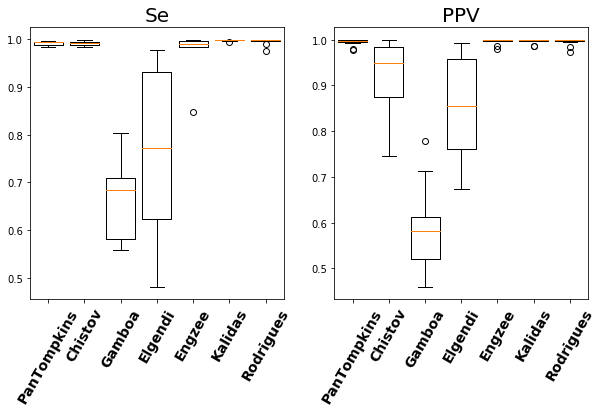

In [19]:
methods = ['pantompkins1985','christov2004','gamboa2008','elgendi2010','engzeemod2012','kalidas2017','rodrigues2020']
name_method = ['PanTompkins','Chistov','Gamboa','Elgendi','Engzee','Kalidas','Rodrigues']


data = {'Method':[],
        'Se_mean':[],
        'Se_std':[],
        'PPV_mean':[],
        'PPV_std':[],
        }
se_p = pd.DataFrame (data)


fig = plt.figure(1, figsize=(10, 5))
ax1 = fig.add_subplot(121) 
plt.title('Se',fontsize = 20)


ax2 = fig.add_subplot(122)   
plt.title('PPV',fontsize = 20)


i = 0
for method in methods:
    thismethod_data = detectors_total_se_p[detectors_total_se_p['Record'].str.contains(methods[i])]
    
    se_mean = np.mean(100 * thismethod_data['Se'])
    se_std = np.std(100 * thismethod_data['Se'])
    p_mean = np.mean(100 * thismethod_data['PPV'])
    p_std = np.std(100 * thismethod_data['PPV'])
    
    
    ax1.boxplot(thismethod_data['Se'], positions = [i], widths = 0.8)
    ax2.boxplot(thismethod_data['PPV'], positions = [i],widths = 0.8)
    
    ax1.set_xticklabels(name_method,rotation=60, fontsize = 14, fontweight='bold')
    ax2.set_xticklabels(name_method,rotation=60, fontsize = 14, fontweight='bold')
    
    
    se_p = se_p.append({'Method':name_method[i], 
                        'Se_mean':se_mean,
                        'Se_std': se_std,
                        'PPV_mean':p_mean,
                        'PPV_std':p_std},
                       ignore_index=True)
    i=i+1
se_p